In [103]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

## Load data

In [3]:
df = pd.read_csv("../data/train.csv")

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Split data

In [6]:
df_train, df_test  = train_test_split(df, test_size=0.2, random_state=23)

## Train a simple model

In [57]:
FEATURES = ['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare']
TARGET = "Survived"
FEATURES

['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare']

In [78]:
model = DecisionTreeClassifier(max_depth=4, random_state=23)

In [79]:
model.fit(df_train[FEATURES], df_train[TARGET])

DecisionTreeClassifier(max_depth=4, random_state=23)

In [80]:
(
    roc_auc_score(df_train[TARGET], model.predict_proba(df_train[FEATURES])[:, 1]), 
    roc_auc_score(df_test[TARGET], model.predict_proba(df_test[FEATURES])[:, 1])
)

(np.float64(0.772730663395551), np.float64(0.7619565217391304))

In [81]:
roc_auc_score(df_test[TARGET], model.predict_proba(df_test[FEATURES])[:, 1])

np.float64(0.7619565217391304)

## Find the best feature

In [82]:
feat_imp = (pd.DataFrame({"feature": model.feature_names_in_, "importance": model.feature_importances_})
    .sort_values("importance", ascending=False))
feat_imp

,feature,importance
4,Fare,0.516175
1,Age,0.326761
2,SibSp,0.113953
0,PassengerId,0.043111
3,Parch,0.000000


## Create a model with only one feature

In [97]:
model = DecisionTreeClassifier(max_depth=2, random_state=23)

In [98]:
FEATURES = ["Fare"]

In [99]:
model.fit(df_train[FEATURES], df_train[TARGET])

DecisionTreeClassifier(max_depth=2, random_state=23)

In [100]:
(
    roc_auc_score(df_train[TARGET], model.predict_proba(df_train[FEATURES])[:, 1]), 
    roc_auc_score(df_test[TARGET], model.predict_proba(df_test[FEATURES])[:, 1])
)

(np.float64(0.6847545005470278), np.float64(0.7552989130434783))

## How tree works

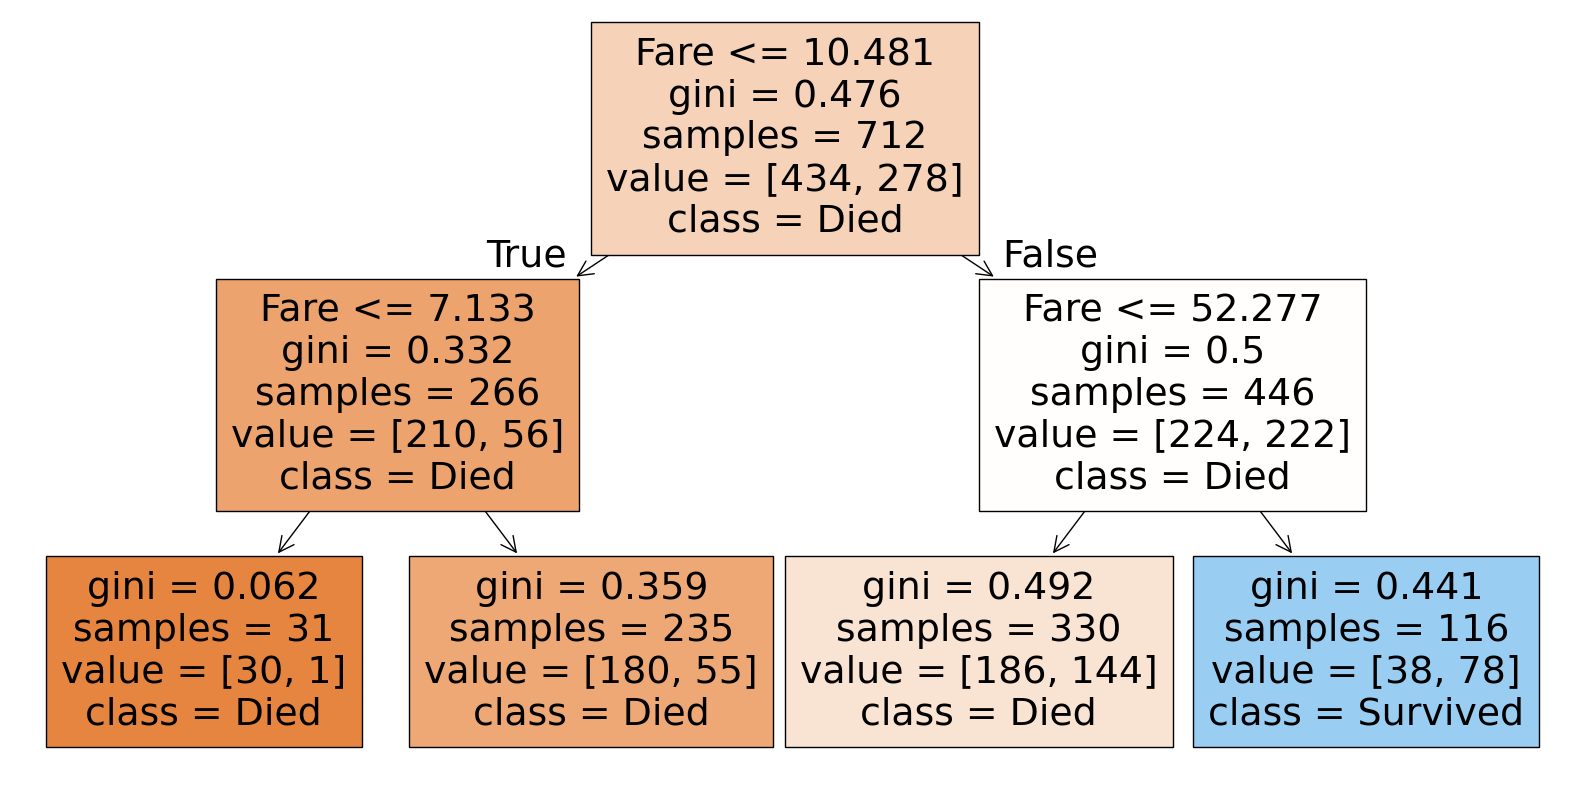

In [101]:
fig, ax = plt.subplots(figsize=(20, 10));
plot_tree(model, ax=ax, feature_names=FEATURES, class_names=["Died", "Survived"], filled=True);

#### Metrics for measuring purity (or impurity)
$gini = 1 - \sum_{i=1}^n p_i^2$

$cross\_entropy = - \sum_{i=1}^n p_i log(p_i)$

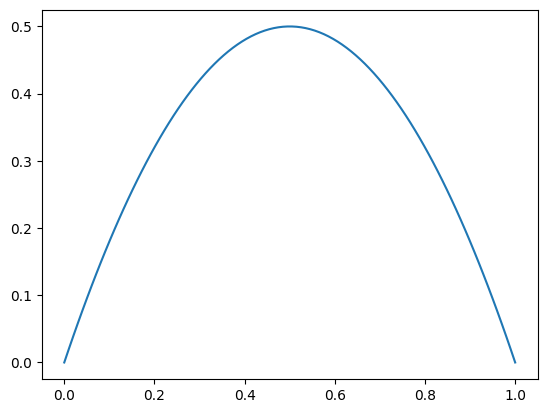

In [111]:
x = np.linspace(0, 1, 100)
gini = 1 - (x**2 + (1-x)**2)

plt.plot(x, gini, label="Gini impurity");

In [102]:
df_train[TARGET].value_counts()

Survived
0    434
1    278
Name: count, dtype: int64

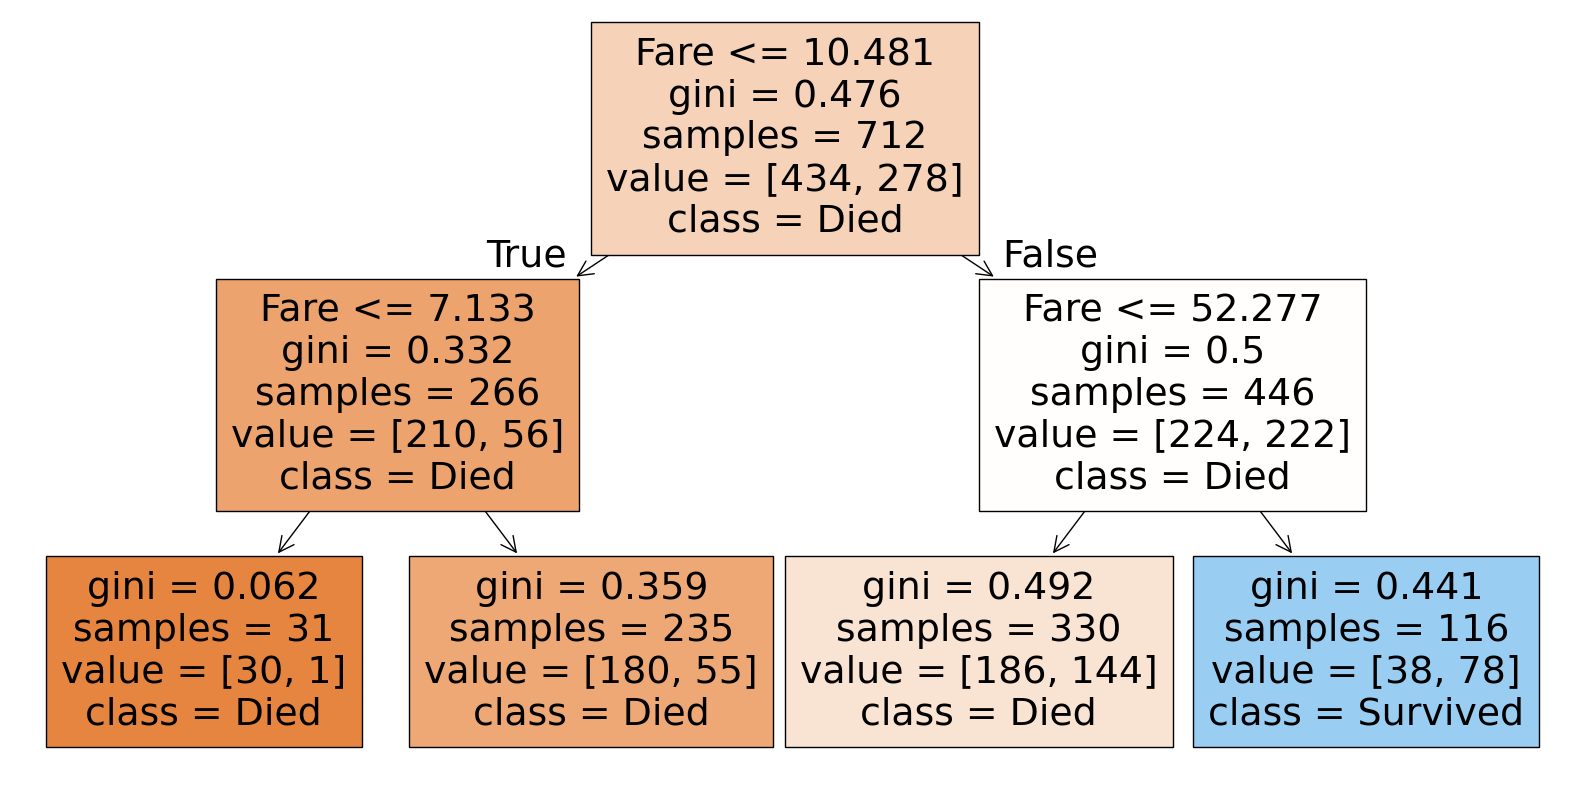

In [115]:
fig, ax = plt.subplots(figsize=(20, 10));
plot_tree(model, ax=ax, feature_names=FEATURES, class_names=["Died", "Survived"], filled=True);

In [134]:
def gini(df):
    p = df[TARGET].mean()
    return 1 - p**2 - (1-p)**2

In [135]:
gini(df_train)

np.float64(0.47599734881959344)

In [136]:
df_sorted = df_train.sort_values("Fare")

In [173]:
fare_values = np.sort(df_train.Fare.unique())
cut_points = (fare_values[:-1] + fare_values[1:]) / 2


In [184]:
def split_tree(df):
    fare_values = np.sort(df.Fare.unique())
    cut_points = (fare_values[:-1] + fare_values[1:]) / 2

    results = {
        "split": [],
        "gini": [],
        "gini_left": [],
        "gini_right": []
    }

    for cut_point in cut_points:
        left = df[df["Fare"] <= cut_point]
        right = df[df["Fare"] > cut_point]
        gini_left = gini(left)
        gini_right = gini(right)
        gini_total = len(left) / len(df) * gini_left + len(right) / len(df) * gini_right
        results["split"].append(cut_point)
        results["gini"].append(gini_total)
        results["gini_left"].append(gini_left)
        results["gini_right"].append(gini_right)

    results = pd.DataFrame(results)

    return results.iloc[results["gini"].idxmin()]

In [185]:
split_tree(df_train)

split         10.481250
gini           0.437383
gini_left      0.332410
gini_right     0.499990
Name: 62, dtype: float64

In [186]:
split_tree(df_train[df_train["Fare"] <= 10.481250])

split         7.133350
gini          0.324026
gini_left     0.062435
gini_right    0.358533
Name: 13, dtype: float64

In [187]:
split_tree(df_train[df_train["Fare"] > 10.481250])

split         52.277100
gini           0.478544
gini_left      0.491901
gini_right     0.440547
Name: 106, dtype: float64